In [1]:
%matplotlib notebook

Here I take all the data from: IAA using single functional Or42a using MS74xMS133 (Or42a-Gal4, UAS-Orco, T17/T32) and the virtual reality experiments using  MS379 (Or42a-Gal4, UAS-Chrimson, T32) and MS133 (+;+;T17). I'll definitely include the gaussian gradient, maybe also the vulcano. If vulcano is included a better name might be to say 'distance to maximum stimulus' instead of distance to source
I'm taking the raw data (i.e. not filtered as for speed plot) to truly reflect what the tracker did while recording and playing back the stimulus!

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import os
import glob
import json
import math
import pickle
from scipy.ndimage.interpolation import affine_transform
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import stats
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# This will change to the default sans-serif font
plt.rcParams["font.family"] = "sans-serif"
# This defines that the default will be Helvetica
#plt.rcParams["font.sans-serif"] = "Arial"
import os
from pathlib import Path
import statsmodels.api as sm

In [3]:
home_path = os.getcwd()

In [4]:
# all the figures will be saved in this folder
target_path = Path('plots/')
os.chdir(home_path)
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [5]:
fps=30 # this is not elegant but true in this case
def frame_to_time(x, pos):
    """
    The two args are the value and tick position
    The first string defines what is shown. %1.1f means that only the first decimal is shown
    x/fps means that for each 'tick', meaning each datapoint the value that is shown is divided by the frames per second.
    This way the actual seconds are displayed
    """
    # CAREFUL!!! was '%1.1f', the 0 makes sure only the value before the decimal dot is shown!!!
    # Make sure your ticks are really integers! 
    return '%1.0f' % (x/fps) # 
# x axis step size for ticks
xtick_size=60

In [6]:
# Randomly subsample as the n for the real odor is higher compared to the virtual reality
# experiments - Can only do it once, of course. Will test if subsample folder
# already exists and will only copy data in case it does NOT.
subsample_data_path_IAA = Path('data/MS74xMS133/subsample/IAA')
original_data_path_IAA = Path('data/MS74xMS133/original/IAA')

subsample_data_path_paraffin = Path('data/MS74xMS133/subsample/Paraffin')
original_data_path_paraffin = Path('data/MS74xMS133/original/Paraffin')


def subsample(subsample_folder, original_folders):
    print('Working on: ' + repr(subsample_folder))
    if os.path.isdir(Path(home_path,subsample_folder)):
        print('Already subsampled!')
    else:
        print('Subsampling now..')
        os.chdir(Path(home_path, original_folders))
        #os.chdir(datapath)
        original_data = [p.replace('\\', '') for p in glob('*MS74*')]
        # Create array from 0 to number of folders and randomly permutate the order
        random_sequence = np.random.permutation(np.arange(0,len(original_data)))
        print('Will take folder #: ' + repr(random_sequence[0:30]))

        for counter, i_folder in enumerate(random_sequence):
            if counter <= 29:
                #print(i_folder)
                print(original_data[i_folder])

                shutil.copytree(original_data[i_folder], 
                                    Path(home_path, subsample_folder, original_data[i_folder]))


subsample(subsample_data_path_IAA, original_data_path_IAA)
subsample(subsample_data_path_paraffin,original_data_path_paraffin)

Working on: WindowsPath('data/MS74xMS133/subsample/IAA')
Already subsampled!
Working on: WindowsPath('data/MS74xMS133/subsample/Paraffin')
Already subsampled!


In [7]:
data_path_IAA = Path('data/MS74xMS133/subsample/IAA/')
os.chdir(home_path)
os.chdir(data_path_IAA)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob.glob('*MS133/')]
# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
source_coordinates_IAA = np.zeros((2,len(folders)))
source_coordinates_IAA.fill(np.nan)
pixel_per_mm_IAA = np.zeros((1, len(folders)))
pixel_per_mm_IAA.fill(np.nan)
recording_time_IAA = np.zeros((1, len(folders)))
recording_time_IAA.fill(np.nan)
fps_IAA = np.zeros((1, len(folders)) )
fps_IAA.fill(np.nan)

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_IAA)
    
    os.chdir(folders[i])
    if i == 0:
        temp = np.load('heads.npy')
        all_heads_IAA = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_IAA.fill(np.nan)
    all_heads_IAA[:,:,i] = np.load('heads.npy')
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_IAA[:,i] = experiment_settings['Pixel per mm']
        recording_time_IAA[:,i] = experiment_settings['Recording time']
        fps_IAA[:,i] = experiment_settings['Framerate']
        source_coordinates_IAA[1,i] = experiment_settings['Source x']
        source_coordinates_IAA[0,i] = experiment_settings['Source y']
    # can calculate distance for each experiment already
    if i == 0:
        distance_IAA = np.zeros((temp.shape[0], len(folders)))
        distance_IAA.fill(np.nan)
    # still don't know how to vectorize eucledian distance...
    for j in range(distance_IAA.shape[0]):
        distance_IAA[j,i] = np.linalg.norm(all_heads_IAA[j,:,i] - 
                                           np.array((source_coordinates_IAA[0,i], source_coordinates_IAA[1,i])))/pixel_per_mm_IAA[:,i]
    

In [8]:
data_path_paraffin_ctr = Path('data/MS74xMS133/subsample/paraffin/')
os.chdir(home_path)
os.chdir(data_path_paraffin_ctr)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob.glob('*MS133/')]
# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
source_coordinates_paraffin_ctr = np.zeros((2,len(folders)))
source_coordinates_paraffin_ctr.fill(np.nan)
pixel_per_mm_paraffin_ctr = np.zeros((1, len(folders)))
pixel_per_mm_paraffin_ctr.fill(np.nan)
recording_time_paraffin_ctr = np.zeros((1, len(folders)))
recording_time_paraffin_ctr.fill(np.nan)
fps_paraffin_ctr = np.zeros((1, len(folders)) )
fps_paraffin_ctr.fill(np.nan)

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_paraffin_ctr)
    
    os.chdir(folders[i])
    if i == 0:
        temp = np.load('heads.npy')
        all_heads_paraffin_ctr = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_paraffin_ctr.fill(np.nan)
    all_heads_paraffin_ctr[:,:,i] = np.load('heads.npy')
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_paraffin_ctr[:,i] = experiment_settings['Pixel per mm']
        recording_time_paraffin_ctr[:,i] = experiment_settings['Recording time']
        fps_paraffin_ctr[:,i] = experiment_settings['Framerate']
        source_coordinates_paraffin_ctr[1,i] = experiment_settings['Source x']
        source_coordinates_paraffin_ctr[0,i] = experiment_settings['Source y']
    # can calculate distance for each experiment already
    if i == 0:
        distance_paraffin_ctr = np.zeros((temp.shape[0], len(folders)))
        distance_paraffin_ctr.fill(np.nan)
    # still don't know how to vectorize eucledian distance...
    for j in range(distance_paraffin_ctr.shape[0]):
        distance_paraffin_ctr[j,i] = np.linalg.norm(all_heads_paraffin_ctr[j,:,i] - 
                                           np.array((source_coordinates_paraffin_ctr[0,i], 
                                                     source_coordinates_paraffin_ctr[1,i])))/pixel_per_mm_paraffin_ctr[:,i]

In [10]:
def plot_fig_dist_to_stimulation(exp_data_median,
                                exp_color,
                                exp_label,
                                exp_data,
                                ctr_data_median,
                                ctr_color,
                                ctr_label,
                                ctr_data):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    ax.set_rasterization_zorder(1)
    
    # plot the median IAA distance to the maximum
    ax.plot(exp_data_median, 
            color = exp_color, 
            label=exp_label + ', n = ' + repr(exp_data.shape[1]), zorder=1)
    # plot all the single tracks with low alpha
    ax.plot(exp_data, 
            alpha = 0.1, 
            color = exp_color, 
            zorder=0)
    # option for plotting the STD - as expected it's horribly large
    #ax.errorbar(x= np.arange(0, std_IAA.shape[0]), y=mean_IAA, yerr=std_IAA, alpha = 0.1, elinewidth =0.001, capsize = 1)
    # plot the median paraffin distance to the maximum
    ax.plot(ctr_data_median, 
            color = ctr_color, 
            label=ctr_label + ', n = ' + repr(ctr_data.shape[1]), 
            zorder=1)
    # plot all the single tracks with low alpha
    ax.plot(ctr_data, 
            alpha = 0.1, 
            color = ctr_color, 
            zorder=0)

    # set the y axis limit
    ax.set_ylim(-3,80)
    # Only draw spine between the y-ticks
    ax.spines['left'].set_bounds(0, 80)
    # label the y axis
    ax.set_ylabel('Distance [mm]', fontsize=20)
    # Can change ticklabel size here, if necessary!
    ax.tick_params(axis='y', labelsize=20)
    # set the yticks
    ax.yaxis.set_ticks(np.arange(0,100, 20))
    # add a minor formatter for y axis
    minorLocator = plticker.MultipleLocator(10)
    ax.yaxis.set_minor_locator(minorLocator)

    # set x axis limit - make sure to have a multiple of the framerate to make sure the ticks are placed in proper distance!
    #start_x_tick, end_x_tick = 0, fps_paraffin_ctr[0][0]*300
    start_x_tick, end_x_tick = 0, 30*300
    ax.set_xlim(start_x_tick-(30*5), end_x_tick)
    # Only draw spine between the y-ticks
    #ax.spines['bottom'].set_bounds(start_x_tick, fps_paraffin_ctr[0][0]*300)
    ax.spines['bottom'].set_bounds(start_x_tick, 30*300)
    # get one tick for every 60 seconds
    #stepsize = int(fps_paraffin_ctr[0][0]*xtick_size)
    stepsize = int(30*xtick_size)
    # set the xticks
    #ax.xaxis.set_ticks(np.arange(start_x_tick, end_x_tick+fps_paraffin_ctr[0][0], stepsize))
    ax.xaxis.set_ticks(np.arange(start_x_tick, end_x_tick+30, stepsize))
    # label the xticks with the seconds by first defining a function...
    x_formatter = plticker.FuncFormatter(frame_to_time)
    # and then giving this function to the major_formatter
    ax.xaxis.set_major_formatter(x_formatter)
    # add a minor formatter for x axis- get minor ticks every 10 seconds
    minorLocator = plticker.MultipleLocator(600)
    ax.xaxis.set_minor_locator(minorLocator)
    # label the x axis
    ax.set_xlabel('Time [s]', fontsize=20)
    # can change ticklabel size here
    ax.tick_params(axis='x', labelsize=20)
    # add a grid
    #ax.grid()


    #ax.set_title('Or42a-Gal4>UAS-Orco, Orco' + r'$^{-/-}$', {'fontsize' : 20}) 
    # if need be we can change a lot of things in the title! 
    #, {'fontsize': rcParams['axes.titlesize'], 'fontweight' : rcParams['axes.titleweight'], 
    # 'verticalalignment': 'baseline', 'horizontalalignment': loc})

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)

    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', width=1, length =5)
    #ax.tick_params(axis='both', which='minor', width =1,length =3)

    ax.minorticks_off()
    ax.legend()

    fig.tight_layout()
    os.chdir(home_path)
    os.chdir(target_path)
    #fig.savefig(exp_label +'_Distance_to_max.eps', rasterized=True, dpi=300)

In [11]:
# plot the distance to source of the chemotaxis assay
median_IAA = np.nanmedian(distance_IAA, axis=1)
std_IAA = np.nanstd(distance_IAA, axis=1)

median_paraffin_ctr = np.nanmedian(distance_paraffin_ctr, axis=1)
std_paraffin_ctr = np.nanstd(distance_paraffin_ctr)

plot_fig_dist_to_stimulation(exp_data_median = median_IAA,
                            exp_color = 'g',
                            exp_label = 'Fig2diii_IAA',
                            exp_data = distance_IAA,
                            ctr_data_median = median_paraffin_ctr,
                            ctr_color = 'k',
                            ctr_label = 'Vehicle',
                            ctr_data = distance_paraffin_ctr)

<IPython.core.display.Javascript object>

C:\Users\David Tadres\.conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:95: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [12]:
############################
# Collect Gaussian-VR data #
############################
# Note - not entirely sure if the selection mechanism (only catch the positive animal_angle experiments) is sufficient
# as it's not really identical to what happend when the arena was first defined - I can't get the last centroid from 
# pre-experiment, though as it's not saved. Maybe I just have to bite the bullet and re-run these experiments!


data_path_gauss = Path('data/MS379xMS133/gaussian_VR_arena/')
os.chdir(home_path)
os.chdir(data_path_gauss)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob.glob('*MS133/')]

# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
gauss_max_coordinates = np.zeros((2,len(folders)))
gauss_max_coordinates.fill(np.nan)
pixel_per_mm_gauss = np.zeros((1, len(folders)))
pixel_per_mm_gauss.fill(np.nan)
recording_time_gauss = np.zeros((1, len(folders)))
recording_time_gauss.fill(np.nan)
fps_gauss = np.zeros((1, len(folders)) )
fps_gauss.fill(np.nan)
real_animal_angle = np.zeros((1, len(folders)))
real_animal_angle.fill(np.nan)

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_gauss)
    
    os.chdir(folders[i])
    print(folders[i])
    if i == 0:
        try:
            temp = np.load('SmA-T-heads.npy')
        except FileNotFoundError:
            temp = np.load('heads.npy')
        all_heads_gauss = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_gauss.fill(np.nan)
        
    try:
        all_heads_gauss[:,:,i] = np.load('SmA-T-heads.npy')
    except FileNotFoundError:
        all_heads_gauss[:,:,i] = np.load('heads.npy')
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_gauss[:,i] = experiment_settings['Pixel per mm']
        recording_time_gauss[:,i] = experiment_settings['Recording time']
        fps_gauss[:,i] = experiment_settings['Framerate']
    
    # get the max value - this will be the center of the gaussian peak
    files = [p.replace('\\', '') for p in glob.glob('*')]
    # get the arena
    for j in range(len(files)):
        if 'csv' and '640x480' in files[j]:
            virtual_arena = np.genfromtxt(files[j], delimiter=',')
    # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
    # the animal)
    max_arena_indices = np.where(virtual_arena == np.amax(virtual_arena))
    # just the the first one as there are only two anyways and it's only used to center the image
    gauss_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
    #print(max_arena_index)
    
    # can calculate distance for each experiment already
    if i == 0:
        distance_gauss = np.zeros((temp.shape[0], len(folders)))
        distance_gauss.fill(np.nan)
        distance_gauss_behing_animal = np.zeros((temp.shape[0], len(folders)))
        distance_gauss_behing_animal.fill(np.nan)
        # preallocate the arena
        gaussian_arena_VR = np.zeros((virtual_arena.shape[0], virtual_arena.shape[1], len(folders)))
    gaussian_arena_VR[:,:,i] = virtual_arena

    #print('folder ' + repr(folders[i]) + ' has real_animal_angle: ' + repr(real_animal_angle) )
    for j in range(distance_gauss.shape[0]):
        distance_gauss[j,i] = np.linalg.norm(all_heads_gauss[j,:,i] - gauss_max_coordinates[:,i])/pixel_per_mm_gauss[:,i]
  
        

21.02.2018_19-25-31_MS379xMS133
21.02.2018_16-44-52_MS379xMS133
21.02.2018_17-15-59_MS379xMS133
21.02.2018_17-28-49_MS379xMS133
21.02.2018_18-31-40_MS379xMS133
20.02.2018_18-44-30_MS379xMS133
20.02.2018_18-54-16_MS379xMS133
20.02.2018_19-09-45_MS379xMS133
20.02.2018_19-01-39_MS379xMS133
21.02.2018_16-13-30_MS379xMS133
21.02.2018_18-40-28_MS379xMS133
2018.12.23_15-13-42_MS379xMS133
2018.12.23_15-20-21_MS379xMS133
2018.12.23_15-26-32_MS379xMS133
2018.12.23_15-11-50_MS379xMS133
2018.12.23_15-18-41_MS379xMS133
2018.12.23_15-24-49_MS379xMS133
2018.12.23_15-37-25_MS379xMS133
2018.12.23_15-16-15_MS379XMS133
2018.12.23_15-22-42_MS379XMS133
2018.12.23_15-29-28_MS379XMS133
2018.12.24_14-26-13_MS379xMS133
2018.12.25_13-53-36_MS379xMS133
2018.12.25_14-00-06_MS379xMS133
2018.12.25_14-08-46_MS379xMS133
2018.12.25_13-57-36_MS379xMS133
2018.12.25_14-06-17_MS379xMS133
2018.12.25_13-57-23_MS379XMS133
2018.12.25_14-06-05_MS379XMS133
2018.12.25_14-16-15_MS379XMS133


In [13]:
##########################################################################
# Create Gaussian-VR control arenas on top of the non-stimulated animals #
##########################################################################

# The proper control for this graph might be to use the data where no VR was present and just pretend to create a VR arena
# and calculate the distance to that fictive (NOT VIRTUAL) arena.
data_path_no_stim = Path('data/MS379xMS133/no_VR_arena/')
os.chdir(home_path)
os.chdir(data_path_no_stim)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob.glob('*MS133/')]

# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
ctr_VR_max_coordinates = np.zeros((2,len(folders)))
ctr_VR_max_coordinates.fill(np.nan)
ctr_VR_max_coordinates_behind_animal=np.zeros((2,len(folders)))
ctr_VR_max_coordinates_behind_animal.fill(np.nan)
pixel_per_mm_ctr_VR = np.zeros((1, len(folders)))
pixel_per_mm_ctr_VR.fill(np.nan)
recording_time_ctr_VR = np.zeros((1, len(folders)))
recording_time_ctr_VR.fill(np.nan)
fps_ctr_VR = np.zeros((1, len(folders)) )
fps_ctr_VR.fill(np.nan)

# take the standard gaussian gradient that was used by all the gaussian experiments 
arena_name = '640x480_gaussian_centred_animal_pos[250,240,0.0].csv'
arena_path = Path('data/MS379xMS133/gaussian_VR_arena/')
os.chdir(home_path)
os.chdir(arena_path)
standard_arena = np.genfromtxt(arena_name, 
                               delimiter=',') # work laptop

# get the initial centroid x and y coordinate
initial_centroid_position_ctr_VR = np.zeros((2, len(folders)))

# some generally true variables as all experiments here employ the same arena
placed_animal_x = int(arena_name.split('animal_pos')[1].split('[')[1].split(',')[0])
placed_animal_y = int(arena_name.split(',')[1].split('[')[0])
placed_animal_theta = float(arena_name.split('animal_pos')[1].split(']')[0].split(',')[-1])
frame_number = 0

# pre-allocated the array to save all the different arenas
gaussian_arena_ctr_VR = np.zeros((standard_arena.shape[0], standard_arena.shape[1], len(folders)))
gaussian_arena_ctr_VR_behind_animal = np.zeros((standard_arena.shape[0], standard_arena.shape[1], len(folders)))

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_no_stim)
    
    os.chdir(folders[i])
    print(folders[i])
    if i == 0:
        try:
            temp = np.load('SmA-T-heads.npy')
        except FileNotFoundError:
            temp = np.load('heads.npy')
        all_heads_ctr_VR = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_ctr_VR.fill(np.nan)
        all_centroids_ctr_VR = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_centroids_ctr_VR.fill(np.nan)
    try:
        all_heads_ctr_VR[:,:,i] = np.load('SmA-T-heads.npy')
        all_centroids_ctr_VR[:,:,i] = np.load('SmA-T-centroids.npy')
    except FileNotFoundError:
        all_heads_ctr_VR[:,:,i] = np.load('heads.npy')
        all_centroids_ctr_VR[:,:,i] = np.load('centroids.npy')
    
    
    files = [p.replace('\\', '') for p in glob.glob('*')]
    
    if 'first_frame_data.pkl' in files:
        data = []
        with (open('first_frame_data.pkl', 'rb')) as openfile:
            while True:
                try:
                    data.append(pickle.load(openfile))
                except EOFError:
                    break
        initial_centroid_position_ctr_VR[0,i] = int(data[0]['centroid row'])
        initial_centroid_position_ctr_VR[1,i] = int(data[0]['centroid col'])
    else:               
        with open('first_frame_data.json', 'r') as file:
            data = json.load(file)
            initial_centroid_position_ctr_VR[:,i] = int(data['centroid row']), int(data['centroid col'])
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_ctr_VR[:,i] = experiment_settings['Pixel per mm']
        recording_time_ctr_VR[:,i] = experiment_settings['Recording time']
        fps_ctr_VR[:,i] = experiment_settings['Framerate']
        
    ###########
    # Translation/Rotation depending on the animal
    # take the standard gaussian arena that is still centered to the middle of the image and do the translation/rotation
    # that would happen during the experiment.
    
    # Difference of the real animal coordinates and the desired coordinates as defined in the VR arena
    #diff_x = initial_centroid_position_ctr_VR[1,i] - placed_animal_x
    #diff_y = initial_centroid_position_ctr_VR[0,i] - placed_animal_y
    diff_x = all_centroids_ctr_VR[frame_number,1,i] - placed_animal_x
    diff_y = all_centroids_ctr_VR[frame_number,0,i] - placed_animal_y

    # First the difference of the real and the desired angle needs to be calculated:

    # The coordinates of the first original animal in int32 space (originally delivered as int16)
    # row/Y THEN # column/X
    first_animal_coordinates = [(initial_centroid_position_ctr_VR[0,i]).astype(np.int32), 
                                (initial_centroid_position_ctr_VR[1,i]).astype(np.int32)]   

    # The coordinates of the animal after it left the original bounding box
    # As the original coordinate is not saved the first centroid that is detected during the experiment is taken.
        # row/Y THEN # column/X
    before_exp_start_animal_coordinates = \
        [(all_centroids_ctr_VR[frame_number,0,i]).astype(np.int32),
         (all_centroids_ctr_VR[frame_number,1,i]).astype(np.int32)] 
    # These two coordinates are used to calculate the direction angle that the animal is coming from.
    # The origin is the first animal.
        # row/Y THEN # column/X
    real_animal_angle = np.arctan2(before_exp_start_animal_coordinates[0] - first_animal_coordinates[0],
                                   before_exp_start_animal_coordinates[1] - first_animal_coordinates[1]) 
    # Then the difference in the real angle of the experiment and the desired angle defined by the VR
    # Arena is calculated
    difference_angle = placed_animal_theta - real_animal_angle

    ###############################
    # In for historical reasons:
    # I've run experiments until September 12th, 2018 with this setting. The problem is that whenever
    # the angle was negative the orientation was inverted! Due to that I was only able to use ~
    # 50% of the collected data so far.
    ##############################
    # Next, all the angles that are currently going from [-0..-pi] (due to arctan2) to are being
    # converted to [pi..2*pi]
    # difference_angle = (difference_angle + np.pi) % np.pi

    # Goal here is to be explicit as speed is probably not really of the essence as this only happens
    # once.

    # First the defined (= placed_animal) coordinates are set to become the origin
    rotation_origin = np.array([[1, 0, -placed_animal_y], # y-coordinate
                                [0, 1, -placed_animal_x], # x-coordinate
                                [0, 0, 1.]])
    # Then the whole arena is rotated at the origin by the difference in angle between the real animal
    # and the defined angle (=placed_animal)
    rotation = np.array([[np.cos(difference_angle), -np.sin(difference_angle), 0],
                          [np.sin(difference_angle), np.cos(difference_angle), 0],
                          [0,0,1]])
    # Then the position of the animal is set back to the original position
    rotation_back = np.array([[1, 0, placed_animal_y], # y-coordinate
                              [0, 1, placed_animal_x], # x-coordinate
                              [0, 0, 1.]])
    # Finally the difference between the x and y position of the real animal and the desired position
    # is stated
    animal_position_difference = np.array([
        [1, 0, diff_y],
        [0, 1, diff_x],
        [0, 0, 1]
    ])
    # Now all these matrices are multplied (@ operator does same as numpy.dot)
    transform = animal_position_difference @ rotation_back @ rotation @ rotation_origin
    '''
    ----   --                 --   --               --   --          --   --                --
    |y'|   |1, 0, Y difference |   |1, 0, Y VR animal|   |cos, -sin, 0|   |1, 0, -Y VR animal| 
    |x'| = |0, 1, X difference | x |0, 1, X VR animal| x |sin, cos,  0| x |0, 1, -X VR animal|
    |0 |   |0, 0, 1            |   |0, 0, 0          |   |0,   0,    1|   |0, 0, 0           |
    ----   --                 --   --               --   --          --   --                --
    '''
    # Need to inverse the transformation matrix (peculiarity of how affine_transform is implemented in scipy.ndimage)
    transformation_matrix = np.linalg.inv(transform)

    # Do an affine tranformation of the original arena using the scipy.ndimage.affine_transform
    # function
    # https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.ndimage.affine_transform.html
    gaussian_arena_ctr_VR[:,:,i] = affine_transform(standard_arena,
                                        transformation_matrix[:2,:2],offset=transformation_matrix[:2,2],
                                        cval=0.0, order =1)
    # END of the Translation/Rotation
    #####################################
    
    # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
    # the animal)
    max_arena_indices = np.where(gaussian_arena_ctr_VR[:,:,i] == np.amax(gaussian_arena_ctr_VR[:,:,i]))
    # just the the first one as there are only two anyways and it's only used to center the image
    ctr_VR_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
    #print(max_arena_index)
    
    
    # can calculate distance for each experiment already
    if i == 0:
        distance_gauss_ctr_VR = np.zeros((temp.shape[0], len(folders)))
        distance_gauss_ctr_VR.fill(np.nan)
    # still don't know how to vectorize eucledian distance...
    for j in range(distance_gauss.shape[0]):
        distance_gauss_ctr_VR[j,i] = np.linalg.norm(all_heads_ctr_VR[j,:,i] - ctr_VR_max_coordinates[:,i])/pixel_per_mm_ctr_VR[:,i]
      
    # save as control_vr
    np.savetxt('gauss_arena_640x480_animal_pos[250,240,0].csv',
                           gaussian_arena_ctr_VR[:,:,i], delimiter=',', fmt='%d')
    
    ##########################################################################################################
    ##########################################################################################################
    ##########################################################################################################
    # also place the arena directly behind the animal
    placed_animal_theta = np.pi
    difference_angle = placed_animal_theta - real_animal_angle

    # Goal here is to be explicit as speed is probably not really of the essence as this only happens
    # once.

    # First the defined (= placed_animal) coordinates are set to become the origin
    rotation_origin = np.array([[1, 0, -placed_animal_y], # y-coordinate
                                [0, 1, -placed_animal_x], # x-coordinate
                                [0, 0, 1.]])
    # Then the whole arena is rotated at the origin by the difference in angle between the real animal
    # and the defined angle (=placed_animal)
    rotation = np.array([[np.cos(difference_angle), -np.sin(difference_angle), 0],
                          [np.sin(difference_angle), np.cos(difference_angle), 0],
                          [0,0,1]])
    # Then the position of the animal is set back to the original position
    rotation_back = np.array([[1, 0, placed_animal_y], # y-coordinate
                              [0, 1, placed_animal_x], # x-coordinate
                              [0, 0, 1.]])
    # Finally the difference between the x and y position of the real animal and the desired position
    # is stated
    animal_position_difference = np.array([
        [1, 0, diff_y],
        [0, 1, diff_x],
        [0, 0, 1]
    ])
    # Now all these matrices are multplied (@ operator does same as numpy.dot)
    transform = animal_position_difference @ rotation_back @ rotation @ rotation_origin
    '''
    ----   --                 --   --               --   --          --   --                --
    |y'|   |1, 0, Y difference |   |1, 0, Y VR animal|   |cos, -sin, 0|   |1, 0, -Y VR animal| 
    |x'| = |0, 1, X difference | x |0, 1, X VR animal| x |sin, cos,  0| x |0, 1, -X VR animal|
    |0 |   |0, 0, 1            |   |0, 0, 0          |   |0,   0,    1|   |0, 0, 0           |
    ----   --                 --   --               --   --          --   --                --
    '''
    # Need to inverse the transformation matrix (peculiarity of how affine_transform is implemented in scipy.ndimage)
    transformation_matrix = np.linalg.inv(transform)

    # Do an affine tranformation of the original arena using the scipy.ndimage.affine_transform
    # function
    # https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.ndimage.affine_transform.html
    gaussian_arena_ctr_VR_behind_animal[:,:,i] = affine_transform(standard_arena,
                                        transformation_matrix[:2,:2],offset=transformation_matrix[:2,2],
                                        cval=0.0, order =1)
                                          
    # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
    # the animal)
    max_arena_indices = np.where(gaussian_arena_ctr_VR_behind_animal[:,:,i] == np.amax(gaussian_arena_ctr_VR_behind_animal[:,:,i]))
    # just the the first one as there are only two anyways and it's only used to center the image
    ctr_VR_max_coordinates_behind_animal[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
    #print(max_arena_index)
    
    
    # can calculate distance for each experiment already
    if i == 0:
        distance_gauss_ctr_VR_behind_animal = np.zeros((temp.shape[0], len(folders)))
        distance_gauss_ctr_VR_behind_animal.fill(np.nan)
    # still don't know how to vectorize eucledian distance...
    for j in range(distance_gauss_ctr_VR_behind_animal.shape[0]):
        distance_gauss_ctr_VR_behind_animal[j,i] = np.linalg.norm(all_heads_ctr_VR[j,:,i] - ctr_VR_max_coordinates_behind_animal[:,i])/pixel_per_mm_ctr_VR[:,i]
      
    # save as control_vr
    
    np.savetxt('behind_animal_gauss_arena_640x480_animal_pos[250,240,0].csv',
                           gaussian_arena_ctr_VR[:,:,i], delimiter=',', fmt='%d')
    

21.02.2018_16-35-51_MS379xMS133
21.02.2018_16-54-05_MS379xMS133
21.02.2018_17-22-42_MS379xMS133
21.02.2018_18-15-57_MS379xMS133
21.02.2018_18-39-27_MS379xMS133
21.02.2018_18-52-16_MS379xMS133
21.02.2018_19-11-22_MS379xMS133
21.02.2018_16-30-25_MS379xMS133
21.02.2018_16-45-46_MS379xMS133
21.02.2018_17-15-04_MS379xMS133
20.02.2018_19-17-41_MS379xMS133
20.02.2018_19-42-13_MS379xMS133
20.02.2018_19-24-16_MS379xMS133
21.02.2018_18-16-50_MS379xMS133
21.02.2018_18-46-53_MS379xMS133
21.02.2018_18-59-37_MS379xMS133
21.02.2018_19-21-00_MS379xMS133
2018.12.24_14-00-12_MS379XMS133
2018.12.24_14-06-29_MS379XMS133
2018.12.24_13-56-18_MS379xMS133
2018.12.24_14-02-33_MS379xMS133
2018.12.25_13-40-13_MS379xMS133
2018.12.25_13-46-50_MS379xMS133
2018.12.25_14-26-35_MS379xMS133
2018.12.25_13-42-50_MS379xMS133
2018.12.25_14-28-26_MS379XMS133


In [14]:
# Plot diplaying the gaussian gradient graph (exp and contr)
median_gauss = np.nanmedian(distance_gauss[0:-10,:], axis=1)
std_gauss = np.nanstd(distance_gauss[0:-10,:], axis=1)
median_gauss_ctr = np.nanmedian(distance_gauss_ctr_VR[0:-10,:], axis=1)
std_gauss_ctr = np.nanstd(distance_gauss_ctr_VR[0:-10,:], axis=1)

plot_fig_dist_to_stimulation(exp_data_median = median_gauss,
                            exp_color = 'r',
                            exp_label = 'Fig2eiii_Gaussian VR',
                            exp_data = distance_gauss[0:-10,:],
                            ctr_data_median = median_gauss_ctr,
                            ctr_color = 'k',
                            ctr_label = 'Control',
                            ctr_data = distance_gauss_ctr_VR[0:-10,:])

<IPython.core.display.Javascript object>

C:\Users\David Tadres\.conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:95: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [15]:
#####################################
# Collect Volcano VR data
#####################################

data_path_volcano = Path('data/MS379xMS133/volcano_VR_arena/')
os.chdir(home_path)
os.chdir(data_path_volcano)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob.glob('*MS133/')]

# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
volcano_max_coordinates = np.zeros((2,len(folders)))
volcano_max_coordinates.fill(np.nan)
pixel_per_mm_volcano = np.zeros((1, len(folders)))
pixel_per_mm_volcano.fill(np.nan)
recording_time_volcano = np.zeros((1, len(folders)))
recording_time_volcano.fill(np.nan)
fps_volcano = np.zeros((1, len(folders)) )
fps_volcano.fill(np.nan)

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_volcano)
    
    os.chdir(folders[i])
    if i == 0:
        try:
            temp = np.load('SmA-T-heads.npy')
        except FileNotFoundError:
            temp = np.load('heads.npy')
        all_heads_volcano = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_volcano.fill(np.nan)
        all_centroids_volcano = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_centroids_volcano.fill(np.nan)
    try:
        all_heads_volcano[:,:,i] = np.load('SmA-T-heads.npy')
        all_centroids_volcano[:,:,i] = np.load('SmA-T-centroids.npy')
    except FileNotFoundError:
        all_heads_volcano[:,:,i] = np.load('heads.npy')
        all_centroids_volcano[:,:,i] = np.load('centroids.npy')
    
    if i == 0:
        temp = np.load('stimulation.npy')
        all_stimulations_volcano = np.zeros((temp.shape[0], len(folders)))
    all_stimulations_volcano[:,i] = np.load('stimulation.npy')
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_volcano[:,i] = experiment_settings['Pixel per mm']
        recording_time_volcano[:,i] = experiment_settings['Recording time']
        fps_volcano[:,i] = experiment_settings['Framerate']
    
    # find all files and look for the csv file that saved the presented arena
    files = [p.replace('\\', '') for p in glob.glob('*')]
    # get the arena
    for j in range(len(files)):
        if 'csv' and '640x480' in files[j]:
            if i == 0:
                temp = np.genfromtxt(files[j], delimiter=',')
                virtual_arenas_volcano = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
                # this array will be used to turn the smooth vulcano into a binary ring (see below)
                max_values_arenas = np.empty_like(virtual_arenas_volcano)
            # save all the virtual volcanoe arenas
            virtual_arenas_volcano[:,:,i] = np.genfromtxt(files[j], delimiter=',')
            
    # it is now necessary to define a useful metric for closeness to the maximum. Maybe everything above 99% of the maximum 
    # counting as the maximum would be good?
    max_values_arenas[:,:,i] = virtual_arenas_volcano[:,:,i] > 0.99*np.amax(virtual_arenas_volcano[:,:,i])
    
    if i == 0:
        minimum_dist_volcano = np.zeros((all_heads_volcano.shape[0], len(folders)))
    
    all_dist = cdist(
        np.asarray((np.where(max_values_arenas[:,:,i]==True)[0], np.where(max_values_arenas[:,:,i]==True)[1])).T, 
        all_heads_volcano[:,:,i])
    minimum_dist_volcano[:,i] = np.amin(all_dist, axis=0)
# convert pixel to mm
minimum_dist_volcano_mm = minimum_dist_volcano/pixel_per_mm_volcano

I can't retrieve the original volcano arena (that is the arena that was used before the experiment to align to the animal) as the Raspberry seems to have died. Need to find a good way to make sure this doesn't happen to users!
For me it shouldn't be a big problem - found one (used) arena that looks as if it's almost exactly in the center. Unfortunately I can't just retranslate/rerotate it as I'm missing the crucial info of the animal after the initial position (before experiment starts). However, I know that the original arena was centered at x=320,y=240.

I can therefore just center the minimum inside the volcanoe to 320,240

<IPython.core.display.Javascript object>


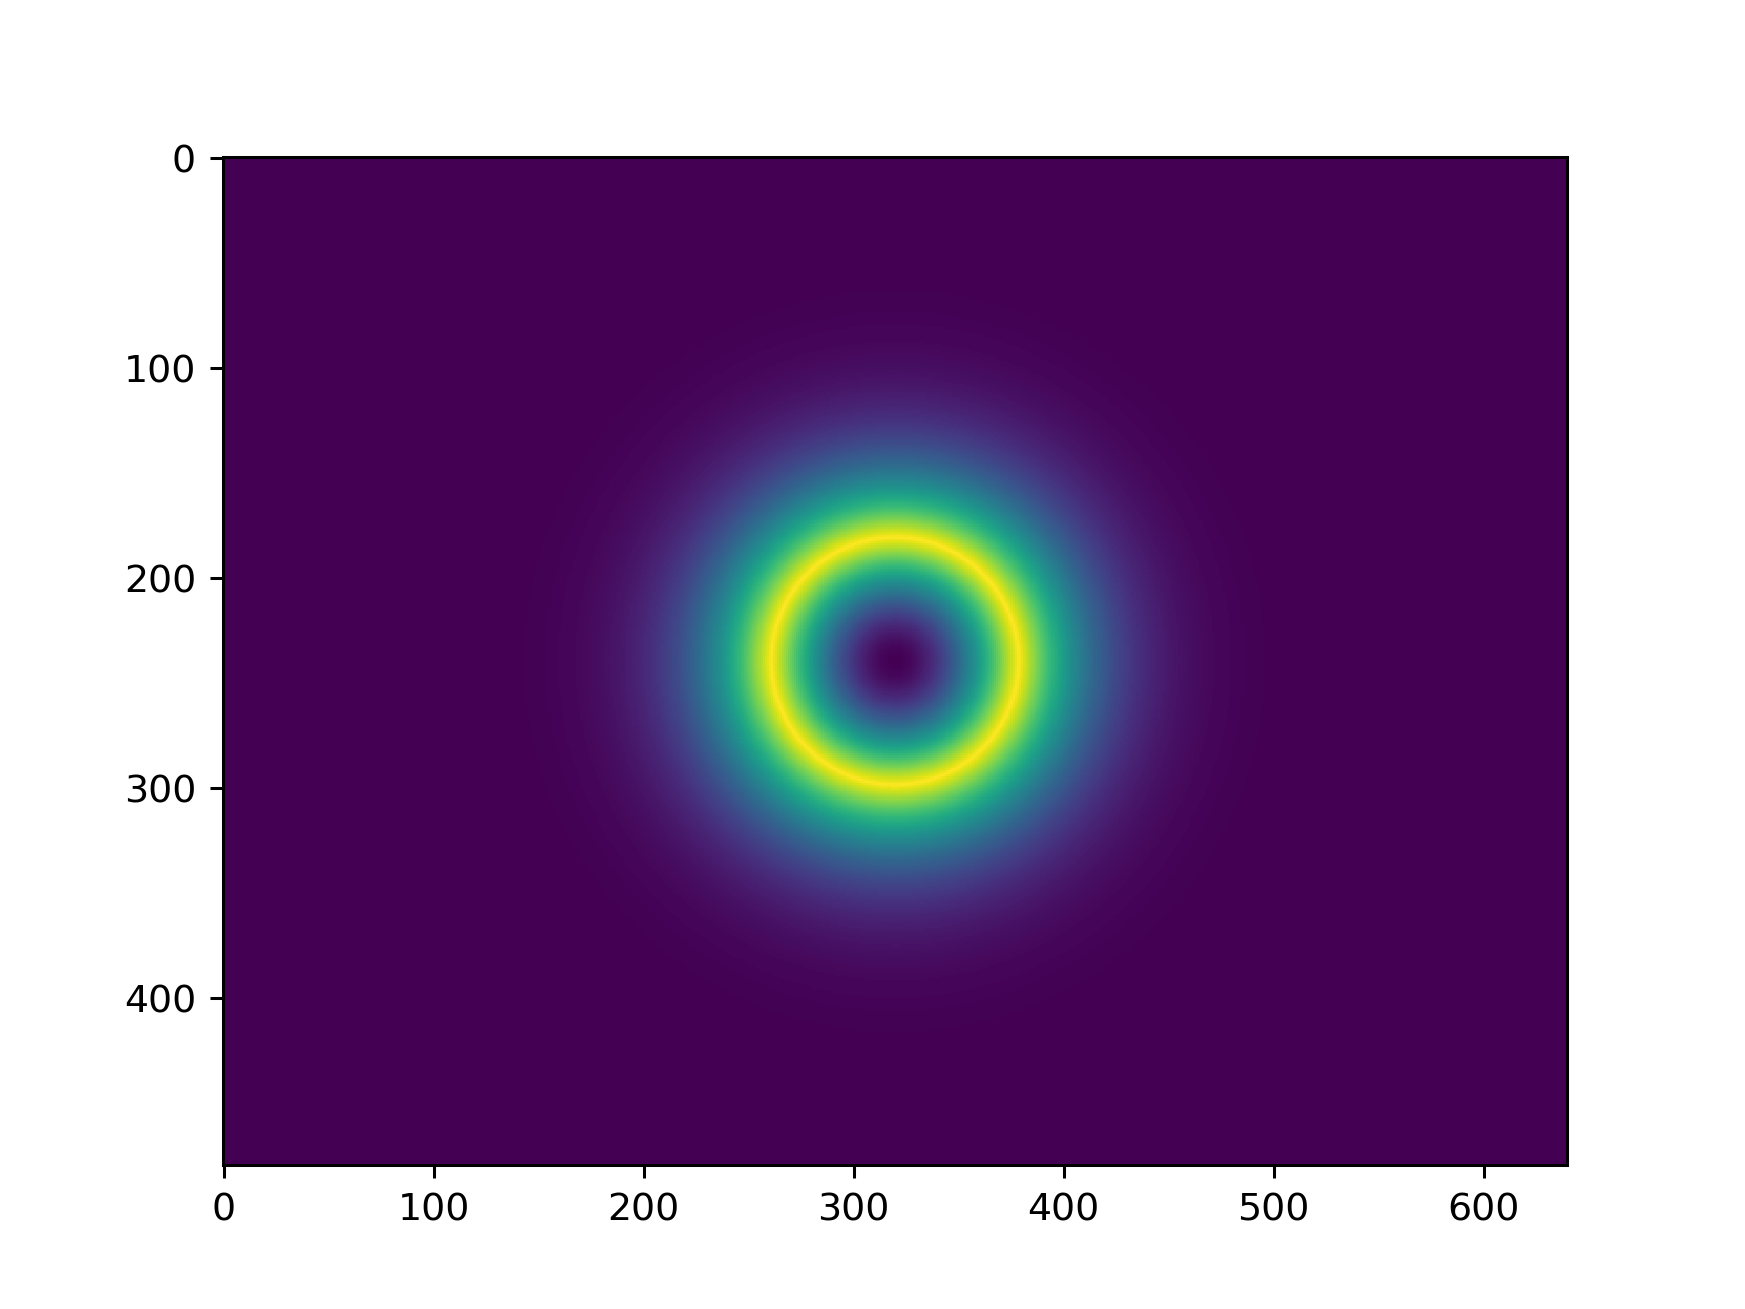

In [16]:
used_arena_path = Path('data/MS379xMS133/volcano_VR_arena/21.02.2018_17-49-17_MS379xMS133/')
os.chdir(home_path)
os.chdir(used_arena_path)

used_arena_data = np.genfromtxt('640x480_vulcano_animal_pos[320,240,0.0].csv', delimiter=',')
first_frame_data = []
with (open('first_frame_data.pkl', 'rb')) as openfile:
    while True:
        try:
            first_frame_data.append(pickle.load(openfile))
        except EOFError:
            break
            
other_data = np.load('SmA-T-centroids.npy')

# get the max values (or the 99.8th perecentile to get a clean ring)
max_values = np.percentile(used_arena_data,99.8)
# create a visualization by creating a zero array
max_arena = np.zeros((used_arena_data.shape[0], used_arena_data.shape[1]))
# and setting everything above to 1
max_arena[np.where(used_arena_data > max_values)[0], np.where(used_arena_data > max_values)[1]] = 1

# find the minimal row and the maximal row
positions_of_ones_rows = np.argmax(max_arena, axis=1)
# minimal row
min_row = np.min(np.nonzero(positions_of_ones_rows))
# max row
max_row = np.max(np.nonzero(positions_of_ones_rows))
# find maximal/minimal columns
position_of_ones_columns = np.argmax(max_arena, axis=0)
min_col = np.min(np.nonzero(position_of_ones_columns))
max_col = np.max(np.nonzero(position_of_ones_columns))
# confirm that it looks alright
#print('min_row ' + repr(min_row))
#print('max_row ' + repr(max_row))
#print('min_col ' + repr(min_col))
#print('max_col ' + repr(max_col))

# calculate the expected distance from the left (columnwise)
current_center_col = min_col + (max_col - min_col)/2
current_center_row = min_row + (max_row - min_row)/2
original_center_col = 640/2
original_center_row = 480/2
#print('current_center_col ' + repr(current_center_col))
#print('current_center_row ' + repr(current_center_row))
#print('original_center_col ' + repr(original_center_col))
#print('original_center_row ' + repr(original_center_row))

# difference between current and original row
diff_row = original_center_row -current_center_row
# difference between current and original col
diff_col = original_center_col - current_center_col
# 'roll' (=translate) the array to the original position, first by rolling the rows (axis 0) then by rolling the columns (axis 1)
original_volcano = np.roll(used_arena_data, int(np.round(diff_row)), axis=0)
original_volcano = np.roll(original_volcano, int(np.round(diff_col)), axis=1)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(original_volcano)

os.chdir(home_path)
os.chdir(target_path)
np.savetxt('volcano.csv',
                       original_volcano, delimiter=',', fmt='%d')

In [17]:
#####################################
# Create the volcano-VR arenas for the non-stimulated runs
#####################################

# The proper control for this graph might be to use the data where no VR was present and just pretend to create a VR arena
# and calculate the distance to that fictive (NOT VIRTUAL) arena.
data_path_no_stim = Path('data/MS379xMS133/no_VR_arena/')
os.chdir(home_path)      
os.chdir(data_path_no_stim)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob.glob('*MS133/')]

# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
volcano_ctr_VR_max_coordinates = np.zeros((2,len(folders)))
volcano_ctr_VR_max_coordinates.fill(np.nan)
pixel_per_mm_volcano_ctr_VR = np.zeros((1, len(folders)))
pixel_per_mm_volcano_ctr_VR.fill(np.nan)
recording_time_volcano_ctr_VR = np.zeros((1, len(folders)))
recording_time_volcano_ctr_VR.fill(np.nan)
fps_volcano_ctr_VR = np.zeros((1, len(folders)) )
fps_volcano_ctr_VR.fill(np.nan)

# get the initial centroid x and y coordinate
initial_centroid_position_volcano_ctr_VR = np.zeros((2, len(folders)))

# some generally true variables as all experiments here employ the same arena
placed_animal_x = 320
placed_animal_y = 240
placed_animal_theta = 0
frame = 0

# pre-allocated the array to save all the different arenas
volcano_arena_ctr_VR = np.zeros((original_volcano.shape[0], original_volcano.shape[1], len(folders)))
max_values_volcano_arena_ctr_VR = np.zeros((original_volcano.shape[0], original_volcano.shape[1], len(folders)))

for i in range(len(folders)):
    os.chdir(home_path)      
    os.chdir(data_path_no_stim)
    
    os.chdir(folders[i])
    print(folders[i])
    if i == 0:
        try:
            temp = np.load('SmA-T-heads.npy')
        except FileNotFoundError:
            temp = np.load('heads')
        all_heads_volcano_ctr_VR = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_volcano_ctr_VR.fill(np.nan)
        all_centroids_volcano_ctr_VR = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_centroids_volcano_ctr_VR.fill(np.nan)
    try:
        all_heads_volcano_ctr_VR[:,:,i] = np.load('SmA-T-heads.npy')
        all_centroids_volcano_ctr_VR[:,:,i] = np.load('SmA-T-centroids.npy')
    except FileNotFoundError:
        all_heads_volcano_ctr_VR[:,:,i] = np.load('heads.npy')
        all_centroids_volcano_ctr_VR[:,:,i] = np.load('centroids.npy')

    files = [p.replace('\\', '') for p in glob.glob('*')]
    if 'first_frame_data.pkl' in files:

        data = []
        with (open('first_frame_data.pkl', 'rb')) as openfile:
            while True:
                try:
                    data.append(pickle.load(openfile))
                except EOFError:
                    break
        initial_centroid_position_volcano_ctr_VR[0,i] = int(data[0]['centroid row']) # Y coordinate
        initial_centroid_position_volcano_ctr_VR[1,i] = int(data[0]['centroid col']) # X coordinate
    else:
        with open('first_frame_data.json', 'r') as file:
            data = json.load(file)
            initial_centroid_position_volcano_ctr_VR[:,i] = int(data['centroid row']), int(data['centroid col'])
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_volcano_ctr_VR[:,i] = experiment_settings['Pixel per mm']
        recording_time_volcano_ctr_VR[:,i] = experiment_settings['Recording time']
        fps_volcano_ctr_VR[:,i] = experiment_settings['Framerate']
        
    ###########
    # Translation/Rotation depending on the animal
    ##########
    
    # Difference of the real animal coordinates and the desired coordinates as defined in the VR arena
    #diff_y = initial_centroid_position_volcano_ctr_VR[0,i] - placed_animal_y # Y coordinate
    #diff_x = initial_centroid_position_volcano_ctr_VR[1,i] - placed_animal_x # X coordinate 
    diff_y = all_centroids_volcano_ctr_VR[frame,0,i] - placed_animal_y # Y coordinate
    diff_x = all_centroids_volcano_ctr_VR[frame,1,i] - placed_animal_x # X coordinate  


    # The coordinates of the first original animal in int32 space (originally delivered as int16)
    # 
    first_animal_coordinates = [(initial_centroid_position_volcano_ctr_VR[0,i]).astype(np.int32), \
                               (initial_centroid_position_volcano_ctr_VR[1,i]).astype(np.int32)]

    # The coordinates of the animal after it left the original bounding box
    # Again: X, THEN Y (before_exp_start_animal_coordinates[0] == X and [1] ==Y!)
    before_exp_start_animal_coordinates = \
        [(all_centroids_volcano_ctr_VR[frame,0,i]).astype(np.int32),
         (all_centroids_volcano_ctr_VR[frame,1,i]).astype(np.int32)]
    # These two coordinates are used to calculate the direction angle that the animal is coming from.
    # The origin is the first animal.
    #real_animal_angle = np.arctan2(first_animal_coordinates[1] - before_exp_start_animal_coordinates[1],
    #                               first_animal_coordinates[0] - before_exp_start_animal_coordinates[0])
    real_animal_angle = np.arctan2(before_exp_start_animal_coordinates[0]-first_animal_coordinates[0],
                                  before_exp_start_animal_coordinates[1]-first_animal_coordinates[1])
    
    # Then the difference in the real angle of the experiment and the desired angle defined by the VR
    # Arena is calculated
    difference_angle = placed_animal_theta - real_animal_angle
    
    # instead of affine transform just use simple translation, rotation to keep stuff simple and less error prone!
    
    volcano_arena_ctr_VR[:,:,i] = ndimage.rotate(original_volcano, np.rad2deg(difference_angle), 
                                                 reshape=False)
    
    
    # translate the arena to the position without rotating yet
    volcano_arena_ctr_VR[:,:,i] = ndimage.interpolation.shift(original_volcano, [diff_y, diff_x])
    
 
    # END of the Translation/Rotation
    #####################################  
    
    # it is now necessary to define a useful metric for closeness to the maximum. Maybe everything above 99% of the maximum 
    # counting as the maximum would be good?
    max_values_volcano_arena_ctr_VR[:,:,i] = volcano_arena_ctr_VR[:,:,i] > 0.99*np.amax(volcano_arena_ctr_VR[:,:,i])
    
    if i == 0:
        minimum_dist_volcano_ctr = np.zeros((all_heads_volcano_ctr_VR.shape[0], len(folders)))
    
    all_dist = cdist(
        np.asarray((np.where(max_values_volcano_arena_ctr_VR[:,:,i]==True)[0], 
                    np.where(max_values_volcano_arena_ctr_VR[:,:,i]==True)[1])).T, 
        all_heads_volcano_ctr_VR[:,:,i])
    minimum_dist_volcano_ctr[:,i] = np.amin(all_dist, axis=0)
    
# distance is saved in pixels, not mm!! Convert here:
minimum_dist_volcano_ctr_mm = minimum_dist_volcano_ctr/pixel_per_mm_volcano_ctr_VR

21.02.2018_16-35-51_MS379xMS133
21.02.2018_16-54-05_MS379xMS133
21.02.2018_17-22-42_MS379xMS133
21.02.2018_18-15-57_MS379xMS133
21.02.2018_18-39-27_MS379xMS133
21.02.2018_18-52-16_MS379xMS133
21.02.2018_19-11-22_MS379xMS133
21.02.2018_16-30-25_MS379xMS133
21.02.2018_16-45-46_MS379xMS133
21.02.2018_17-15-04_MS379xMS133
20.02.2018_19-17-41_MS379xMS133
20.02.2018_19-42-13_MS379xMS133
20.02.2018_19-24-16_MS379xMS133
21.02.2018_18-16-50_MS379xMS133
21.02.2018_18-46-53_MS379xMS133
21.02.2018_18-59-37_MS379xMS133
21.02.2018_19-21-00_MS379xMS133
2018.12.24_14-00-12_MS379XMS133
2018.12.24_14-06-29_MS379XMS133
2018.12.24_13-56-18_MS379xMS133
2018.12.24_14-02-33_MS379xMS133
2018.12.25_13-40-13_MS379xMS133
2018.12.25_13-46-50_MS379xMS133
2018.12.25_14-26-35_MS379xMS133
2018.12.25_13-42-50_MS379xMS133
2018.12.25_14-28-26_MS379XMS133


<IPython.core.display.Javascript object>


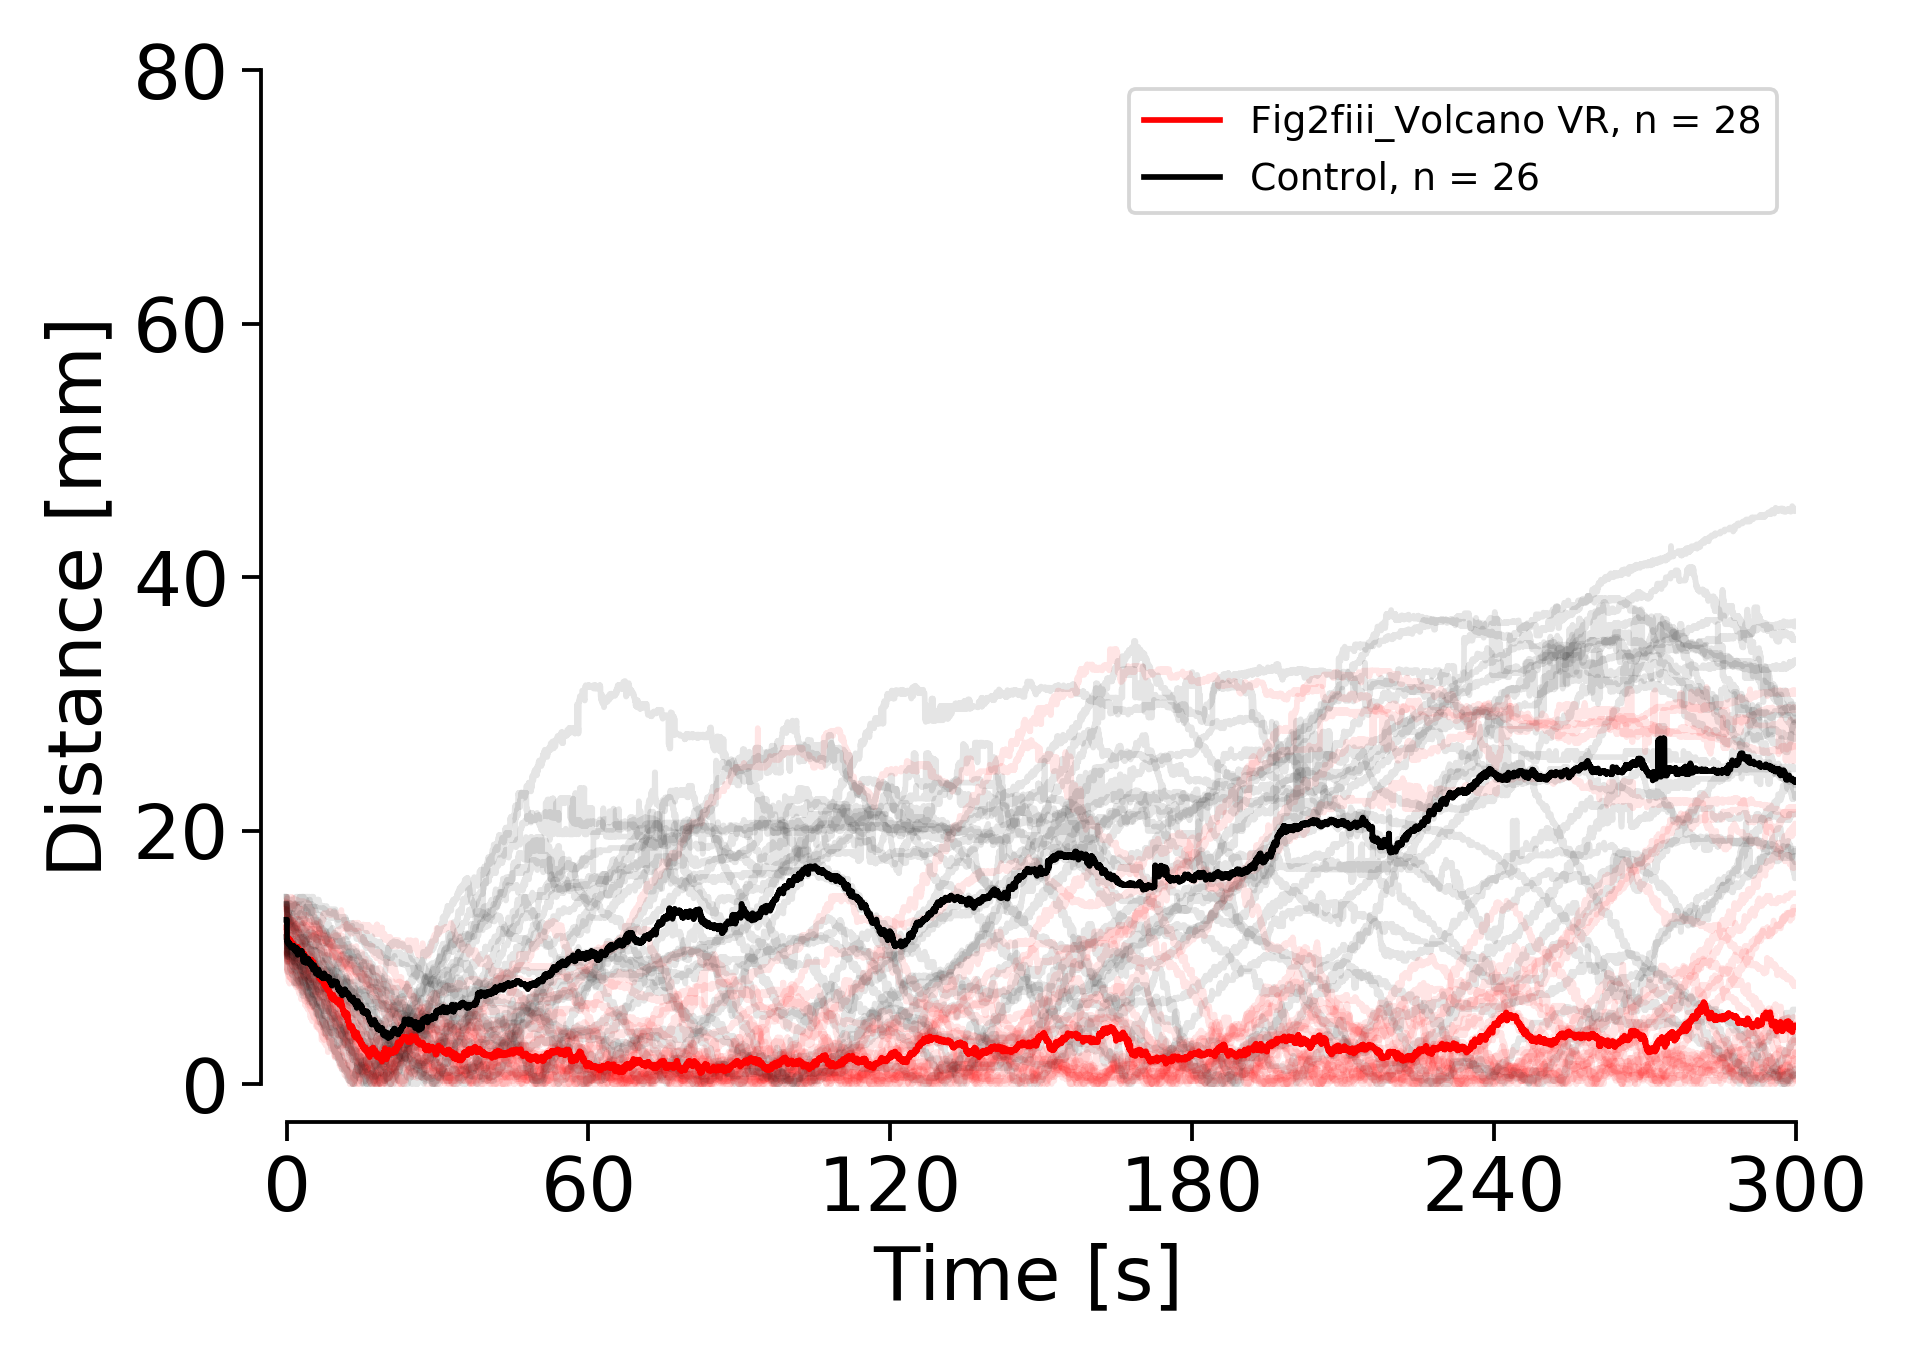

C:\Users\David Tadres\.conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:95: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [18]:
median_minimum_dist_volcano = np.nanmedian(minimum_dist_volcano_mm[0:-1], axis=1)
std_minimum_dist_volcano = np.nanstd(minimum_dist_volcano_mm, axis=1)
median_minimum_dist_volcano_ctr = np.nanmedian(minimum_dist_volcano_ctr_mm[0:-1], axis=1)

plot_fig_dist_to_stimulation(exp_data_median = median_minimum_dist_volcano,
                            exp_color = 'r',
                            exp_label = 'Fig2fiii_Volcano VR',
                            exp_data = minimum_dist_volcano_mm[0:-1],
                            ctr_data_median = median_minimum_dist_volcano_ctr,
                            ctr_color = 'k',
                            ctr_label = 'Control',
                            ctr_data = minimum_dist_volcano_ctr_mm[0:-1])

In [19]:
#Calculate the p-Value: take a timepoint well into the experiment, e.g. at 4 minutes and just calculate
# the difference between the two groups..

timepoint = 4*60
timepoint *= 30

def do_stats(exp, ctr):
    """
    To do a parametric test (the T-test in this case) we need to test for both normal distribution 
    of the data (Shapior-Wilk) and for Homogeneity of Variance between the tested groups (Levene's Test).
    This function makes it easy to display test values    
    """
    print("\nlilliefors exp: " + repr(sm.stats.lilliefors(exp)[1]), 
     "lilliefors ctr: " + repr(sm.stats.lilliefors(ctr)[1])) 
    print(stats.levene(exp,ctr))
    print(stats.ranksums(exp,ctr))

print('IAA')
do_stats(distance_IAA[timepoint],distance_paraffin_ctr[timepoint])

print('\nGaussian')
do_stats(distance_gauss[timepoint][np.where(~np.isnan(distance_gauss[timepoint]))],
                                                             distance_gauss_ctr_VR_behind_animal[timepoint])

print('\nVolcano')
do_stats(minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))],
                                      minimum_dist_volcano_ctr_mm[timepoint])

IAA

lilliefors exp: 3.892165002337862e-10 lilliefors ctr: 0.2
LeveneResult(statistic=2.5911346359954863, pvalue=0.1128932286526017)
RanksumsResult(statistic=-5.337177576292016, pvalue=9.44045721202458e-08)

Gaussian

lilliefors exp: 0.0007145313519549918 lilliefors ctr: 0.2
LeveneResult(statistic=6.9416494277280965, pvalue=0.010966140177591887)
RanksumsResult(statistic=-4.961498184774118, pvalue=6.995152421399371e-07)

Volcano

lilliefors exp: 0.00012651256305461472 lilliefors ctr: 0.10415316691949902
LeveneResult(statistic=2.354450551849296, pvalue=0.13098832794184329)
RanksumsResult(statistic=-3.704736822646775, pvalue=0.00021161032378598263)


In [21]:
# plot S7a (distance to source compared between exp and ctr at timepoint 4 minutes)
positions = [0, 0.25]

fig = plt.figure()
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

x_IAA = np.random.normal(positions[1], 0.03, size=distance_IAA[timepoint].shape[0])
x_IAA_ctr = np.random.normal(positions[0], 0.03, size=distance_paraffin_ctr[timepoint].shape[0])

ax.scatter(x=x_IAA, y=distance_IAA[timepoint],
           alpha=0.3, 
           color='b', 
           label='IAA',
           zorder=0)
ax.boxplot(distance_IAA[timepoint],
           positions=[positions[1]],
           showfliers=False,
           notch=True,
           zorder=1)

# plot paraffin
ax.scatter(x=x_IAA_ctr, y=distance_paraffin_ctr[timepoint], 
           alpha=0.3, 
           color='k', 
           label='paraffin',
           zorder=0)
ax.boxplot(distance_paraffin_ctr[timepoint], 
           positions=[positions[0]], 
           showfliers=False,
           notch=True,
           zorder=1)

ax.set_xlim(-0.5,positions[-1]+1)
ax.set_ylim(-1.1,90)
ax.set_xlim(positions[0]-0.5,positions[-1]+0.5)

ax.set_xticks(ticks=positions)

ax.set_yticks(ticks=[0,25,50,75])
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Distance [mm]', fontsize=20)


#ax.set_xticklabels(['Gr66a-Gal4','empty-Gal4'], fontsize=20, rotation=10)
ax.set_xticklabels(['paraffin', 'IAA'],#, 'VR Gauss', 'Ctr VR Gauss', 'VR Volc', 'Ctr VR Volc'],
                  rotation=45, fontsize=20)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# modify spines on the left
ax.spines['left'].set_bounds(0,75)

fig.tight_layout()

os.chdir(home_path)
os.chdir(target_path)
fig.savefig('Fig2S7a.eps', rasterized=True, dpi=300)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


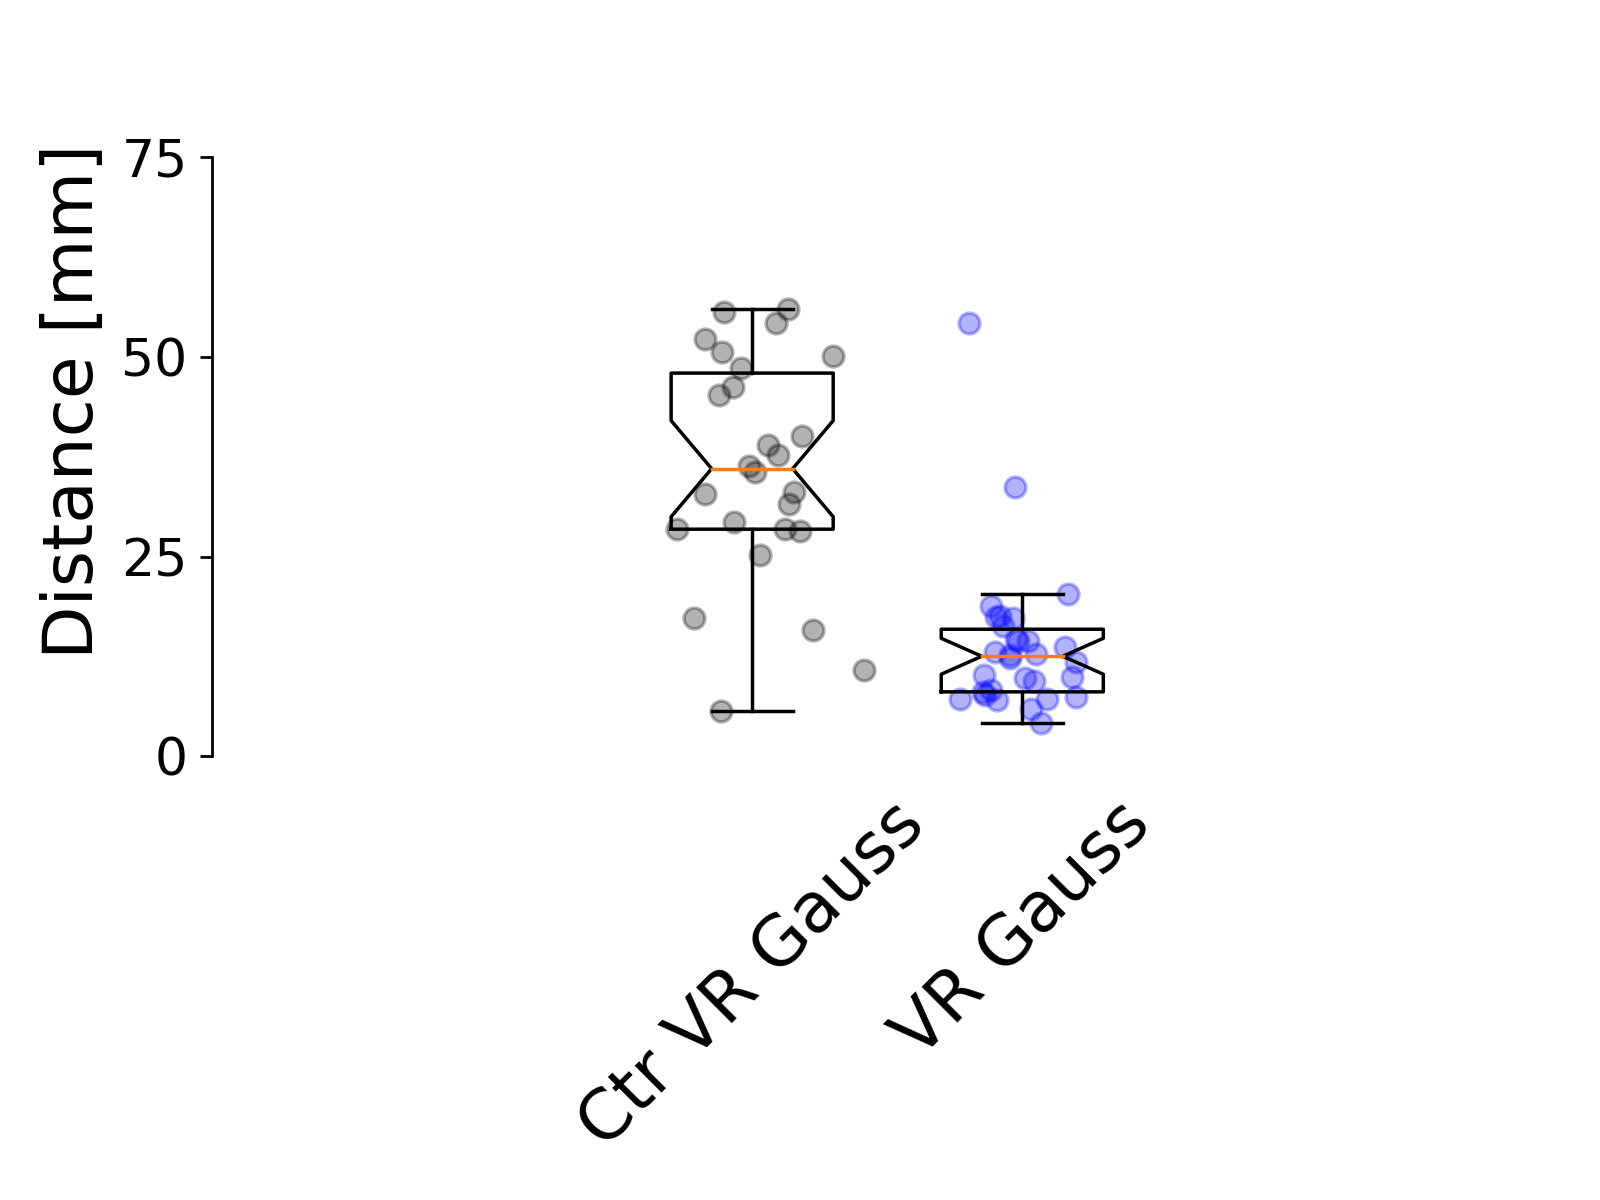

In [37]:
# plot S7b (distance to source compared between exp and ctr at timepoint 4 minutes)
positions = [0, 0.25]

fig = plt.figure()
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

x_gaussian = np.random.normal(positions[1], 0.03, size=distance_gauss[timepoint]
                                           [np.where(~np.isnan(distance_gauss[timepoint]))].shape[0])
x_gaussian_ctr = np.random.normal(positions[0], 0.03, size=distance_gauss_ctr_VR_behind_animal[timepoint].shape[0])

# plot gaussian VR
ax.scatter(x=x_gaussian, y=distance_gauss[timepoint]
                                           [np.where(~np.isnan(distance_gauss[timepoint]))], 
           alpha=0.3, 
           color='b', 
           label='gaussian',
           zorder=0)
ax.boxplot(distance_gauss[timepoint][np.where(~np.isnan(distance_gauss[timepoint]))],
           positions=[positions[1]], showfliers=False,notch=True,zorder=1)
# plot gaussian VR control
ax.scatter(x=x_gaussian_ctr, y=distance_gauss_ctr_VR_behind_animal[timepoint], 
           alpha=0.3, 
           color='k', 
           label='gaussian ctr',
           zorder=0)
ax.boxplot(distance_gauss_ctr_VR_behind_animal[timepoint], 
           positions=[positions[0]], 
           showfliers=False, 
           notch=True,
           zorder=1)

ax.set_xlim(positions[0]-0.5,positions[-1]+0.5)
ax.set_ylim(-1.1,90)


ax.set_xticks(ticks=positions)

ax.set_yticks(ticks=[0,25,50,75])
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Distance [mm]', fontsize=20)

ax.set_xticklabels(['Ctr VR Gauss','VR Gauss'],#, 'VR Gauss', 'Ctr VR Gauss', 'VR Volc', 'Ctr VR Volc'],
                  rotation=45, fontsize=20)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# modify spines on the left
ax.spines['left'].set_bounds(0,75)

fig.tight_layout()

os.chdir(home_path)
os.chdir(target_path)
fig.savefig('Fig2S7b.eps', rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


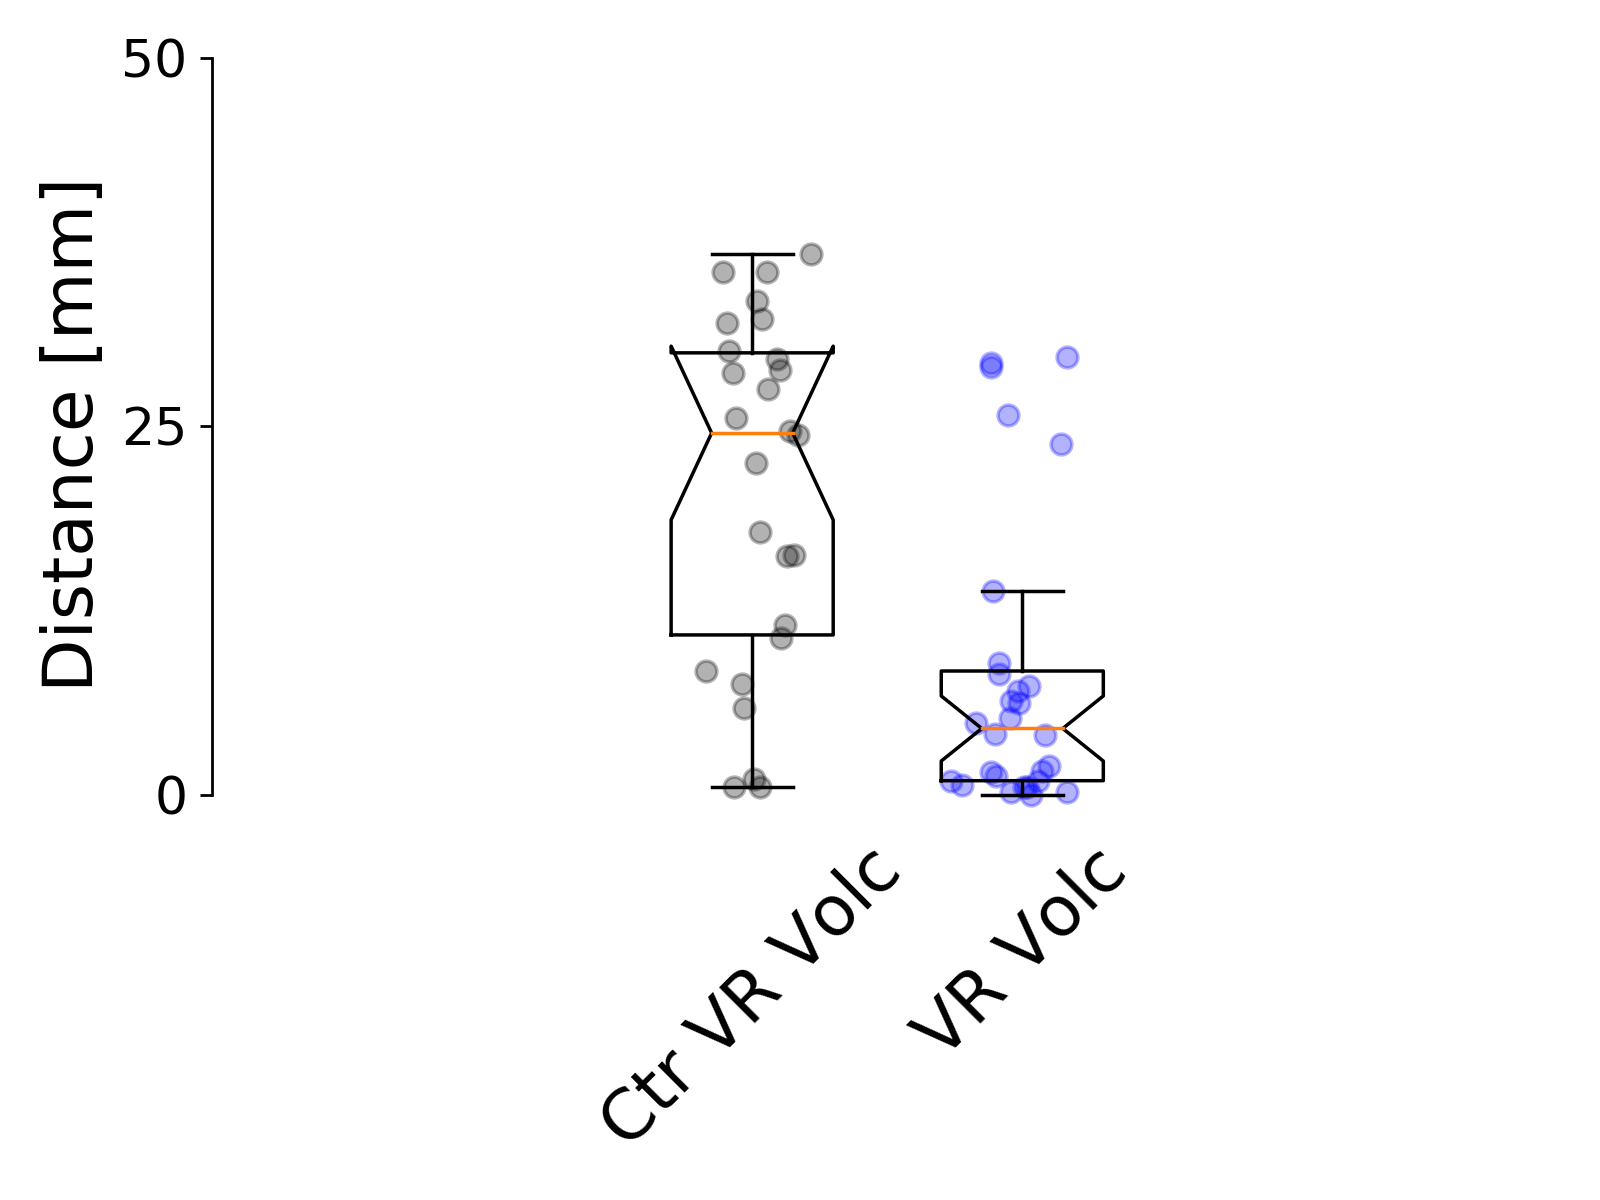

In [38]:
# plot S7C (distance to source compared between exp and ctr at timepoint 4 minutes)
positions = [0, 0.25]

fig = plt.figure()
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

x_volcano = np.random.normal(positions[1], 0.03, size=minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))].shape[0])
x_volcano_ctr = np.random.normal(positions[0], 0.03, size=minimum_dist_volcano_ctr_mm[timepoint].shape[0])


# plot volcano VR
ax.scatter(x=x_volcano, y=minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))], 
           alpha=0.3, 
           color='b', 
           label='volcano',
           zorder=0)
ax.boxplot(minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))], 
           positions=[positions[1]], 
           showfliers=False,
           notch=True,
           zorder=1)
# plot gaussian VR control
ax.scatter(x=x_volcano_ctr, y=minimum_dist_volcano_ctr_mm[timepoint],
           alpha=0.3, 
           color='k', 
           label='gaussian ctr',
           zorder=0)
ax.boxplot(minimum_dist_volcano_ctr_mm[timepoint], 
           positions=[positions[0]], 
           showfliers=False,
           notch=True,
           zorder=1)


ax.set_xlim(-0.5,positions[-1]+1)
ax.set_ylim(-1.1,50)
ax.set_xlim(positions[0]-0.5,positions[-1]+0.5)

ax.set_xticks(ticks=positions)

ax.set_yticks(ticks=[0,25,50])
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Distance [mm]', fontsize=20)


#ax.set_xticklabels(['Gr66a-Gal4','empty-Gal4'], fontsize=20, rotation=10)
ax.set_xticklabels(['Ctr VR Volc', 'VR Volc'],#, 'VR Gauss', 'Ctr VR Gauss', 'VR Volc', 'Ctr VR Volc'],
                  rotation=45, fontsize=20)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# modify spines on the left
ax.spines['left'].set_bounds(0,50)

fig.tight_layout()

os.chdir(home_path)
os.chdir(target_path)
fig.savefig('Fig2S7C.eps', rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


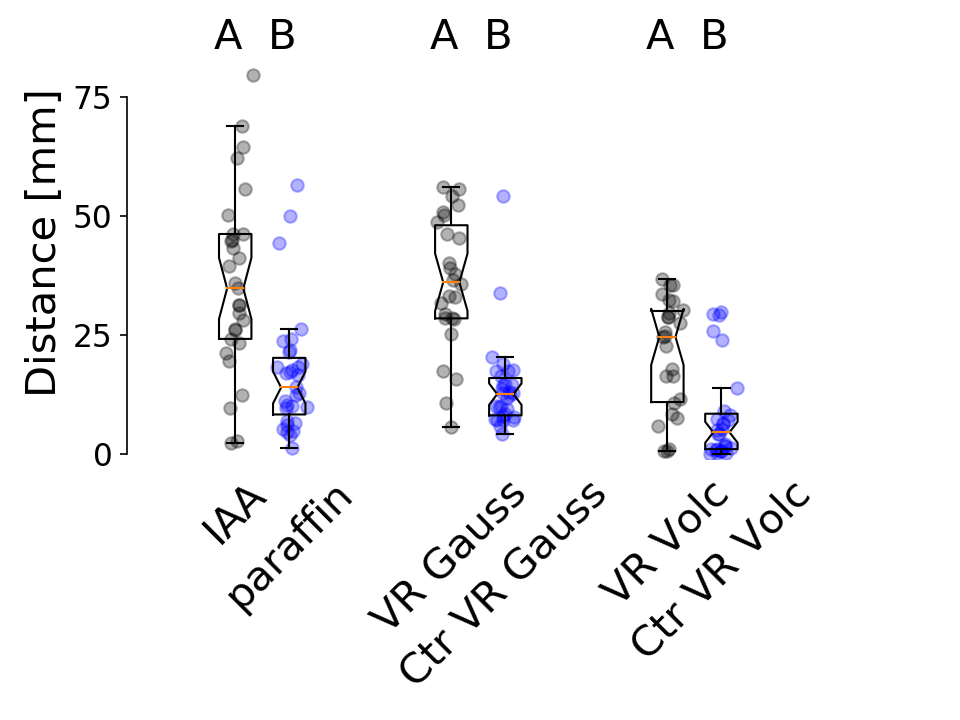

In [18]:
# plot the distance to maximum in boxplot

positions = [0,0.25,1,1.25,2,2.25]

x_IAA = np.random.normal(positions[1], 0.03, size=distance_IAA[timepoint].shape[0])
x_IAA_ctr = np.random.normal(positions[0], 0.03, size=distance_paraffin_ctr[timepoint].shape[0])
#x_empty = np.random.normal(0.5, 0.03, size=len(preference_index_empty_10))

x_gaussian = np.random.normal(positions[3], 0.03, size=distance_gauss[timepoint]
                                           [np.where(~np.isnan(distance_gauss[timepoint]))].shape[0])
x_gaussian_ctr = np.random.normal(positions[2], 0.03, size=distance_gauss_ctr_VR_behind_animal[timepoint].shape[0])

x_volcano = np.random.normal(positions[5], 0.03, size=minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))].shape[0])
x_volcano_ctr = np.random.normal(positions[4], 0.03, size=minimum_dist_volcano_ctr_mm[timepoint].shape[0])


fig = plt.figure()
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)
#ax.grid(alpha=0.5, axis='y', zorder = 0)
# plot IAA
ax.scatter(x=x_IAA, y=distance_IAA[timepoint],
           alpha=0.3, 
           color='b', 
           label='IAA',
           zorder=0)
ax.boxplot(distance_IAA[timepoint],
           positions=[positions[1]],
           showfliers=False,
           notch=True,
           zorder=1)
# plot paraffin
ax.scatter(x=x_IAA_ctr, y=distance_paraffin_ctr[timepoint], 
           alpha=0.3, 
           color='k', 
           label='paraffin',
           zorder=0)
ax.boxplot(distance_paraffin_ctr[timepoint], 
           positions=[positions[0]], 
           showfliers=False,
           notch=True,
           zorder=1)

# plot gaussian VR
ax.scatter(x=x_gaussian, y=distance_gauss[timepoint]
                                           [np.where(~np.isnan(distance_gauss[timepoint]))], 
           alpha=0.3, 
           color='b', 
           label='gaussian',
           zorder=0)
ax.boxplot(distance_gauss[timepoint][np.where(~np.isnan(distance_gauss[timepoint]))],
           positions=[positions[3]], showfliers=False,notch=True,zorder=1)
# plot gaussian VR control
ax.scatter(x=x_gaussian_ctr, y=distance_gauss_ctr_VR_behind_animal[timepoint], 
           alpha=0.3, 
           color='k', 
           label='gaussian ctr',
           zorder=0)
ax.boxplot(distance_gauss_ctr_VR_behind_animal[timepoint], 
           positions=[positions[2]], 
           showfliers=False, 
           notch=True,
           zorder=1)

# plot volcano VR
ax.scatter(x=x_volcano, y=minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))], 
           alpha=0.3, 
           color='b', 
           label='volcano',
           zorder=0)
ax.boxplot(minimum_dist_volcano_mm[timepoint]
                                       [np.where(~np.isnan(minimum_dist_volcano_mm[timepoint]))], 
           positions=[positions[5]], 
           showfliers=False,
           notch=True,
           zorder=1)
# plot gaussian VR control
ax.scatter(x=x_volcano_ctr, y=minimum_dist_volcano_ctr_mm[timepoint],
           alpha=0.3, 
           color='k', 
           label='gaussian ctr',
           zorder=0)
ax.boxplot(minimum_dist_volcano_ctr_mm[timepoint], 
           positions=[positions[4]], 
           showfliers=False,
           notch=True,
           zorder=1)


#ax.plot([-0.05, 0.05],[np.nanmedian(preference_index_gr66a),np.nanmedian(preference_index_gr66a)], 'k-', lw=2)
#ax.scatter(x=x_empty, y=preference_index_empty_10, alpha =0.3, color='k', label='empty-Gal4')
#ax.boxplot(preference_index_empty_10, positions=[0.5], showfliers=False)
ax.set_xlim(-0.5,positions[-1]+1)
ax.set_ylim(-1.1,90)

#ax.plot([-0.1,0.6],[1.1,1.1], color='k')
#ax.text(x=0.15, y=1.15, s='p < 0.001', fontsize=15)
ax.text(positions[0]-0.1, 85, s='A', fontsize=20)
ax.text(positions[1]-0.1, 85, s='B', fontsize=20)

ax.text(positions[2]-0.1, 85, s='A', fontsize=20)
ax.text(positions[3]-0.1, 85, s='B', fontsize=20)

ax.text(positions[4]-0.1, 85, s='A', fontsize=20)
ax.text(positions[5]-0.1, 85, s='B', fontsize=20)

ax.set_xticks(ticks=positions)

ax.set_yticks(ticks=[0,25,50,75])
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Distance [mm]', fontsize=20)


#ax.set_xticklabels(['Gr66a-Gal4','empty-Gal4'], fontsize=20, rotation=10)
ax.set_xticklabels(['IAA', 'paraffin', 'VR Gauss', 'Ctr VR Gauss', 'VR Volc', 'Ctr VR Volc'],
                  rotation=45, fontsize=20)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# modify spines on the left
ax.spines['left'].set_bounds(0,75)
#ax.spines['left'].set_linewidth(2)
#
#ax.set_title('Distance at timepoint ' + repr(round(timepoint/60/30)) + 'min',fontsize=20)

#for key in legend_dict:
#        data_key = mpatches.Patch(color=legend_dict[key], label=key)
#        ax.set_xlabel(key, fontsize=0)
#        patchList.append(data_key)
#fig.legend(fontsize=20, framealpha=0.5)

fig.tight_layout()

os.chdir(home_path)
os.chdir(target_path)
#fig.savefig('Fig2S1a_p-values.eps')#, rasterized=True, dpi=300)
